In [40]:
import numpy as np
import matplotlib.pyplot as plt
from qubit_zz_coupling.core import setup_operators, solve_t1, solve_t2, make_population, plot_t1, plot_t2
from qutip import basis, tensor
from qtt.algorithms.functions import gauss_ramsey, fit_gauss_ramsey, plot_gauss_ramsey_fit

from qutip import basis, tensor, sigmaz, sigmax, sigmaz, sigmam, sigmap, mesolve, identity, Qobj, destroy, qeye
from tqdm import tqdm


In [41]:
def tls_f_shift(t, f0, v0, T, phi=0):
    return f0 - (v0*np.sin( (2*np.pi* t / T) + phi))


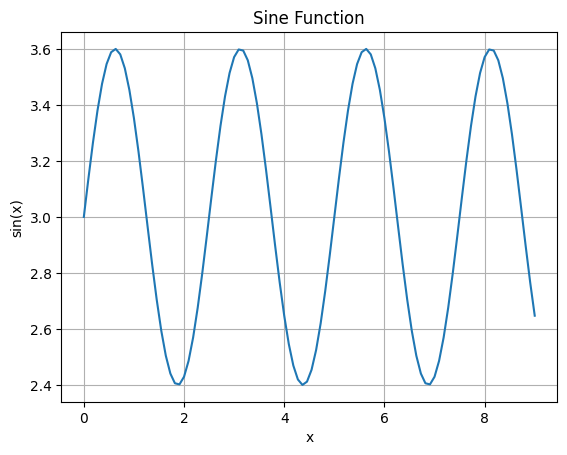

In [42]:
x = np.linspace(0, 9, 100)  # 0 to X
y = tls_f_shift(x, 3.0, 0.6, 2.5, np.pi)

plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.title('Sine Function')
plt.grid(True)
plt.show()

In [43]:
def sz_analytic(tlist, g):
    return np.cos(2 * np.pi * tlist) * np.exp(-tlist * g)

In [61]:
# Define system parameters
SYSTEM_PARAMS = {
    "fq1": 3.2,  # GHz, Qubit 1 frequency
    "fq2": 3.35,  # GHz, Qubit 2 frequency
    "fTLS": 3.2,  # GHz, TLS frequency (resonant with Qubit 1)
    "JTLS": 0.05,  # GHz, Coupling strength between Qubit 1 and TLS
    "relaxation": {"q1": 1/200, "q2": 1/250, "TLS": 1/500},  # Relaxation rates
    "dephasing": {"q1": 1/150, "q2": 1/180, "TLS": 1/300},  # Dephasing rates
    "Jzz": 0.00, # Jzz coupling
    "Jxx": 0.00, # Jxx coupling
    "Jxt": 0.00, # Jxt coupling
    "time_points": np.linspace(0, 300, 120)  # Time points in μs
}

H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=SYSTEM_PARAMS)

# get times
tlist = SYSTEM_PARAMS["time_points"]

# T1 measurement for Qubit 1 

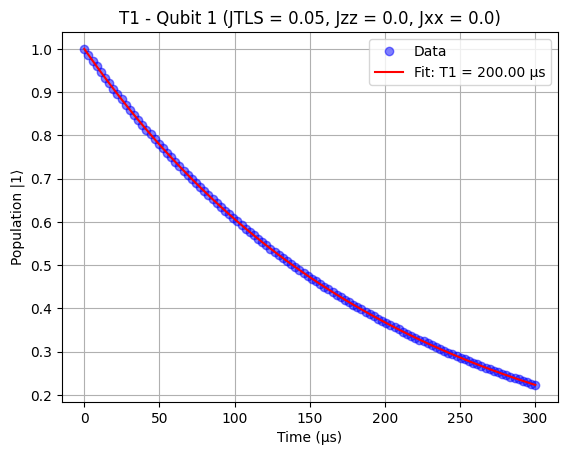

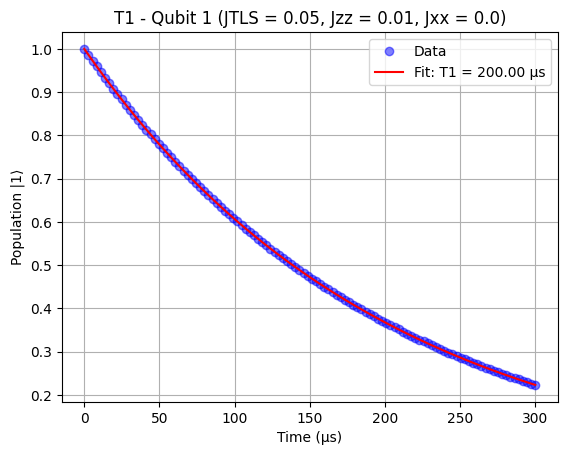

In [5]:
# T1 measurement for Qubit 1 
psi0 = tensor(basis(2,0), basis(2,1), basis(2,1))  # |0⟩|1⟩|1⟩

solve_t1(H, psi0, tlist, c_ops, [sz_q1], ret_pop=False)
plot_t1(H, psi0, tlist, c_ops, [sz_q1], "Qubit 1", SYSTEM_PARAMS)


# with coupling
SYSTEM_PARAMS["Jzz"] = 0.01
H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=SYSTEM_PARAMS)

psi0 = tensor(basis(2,0), basis(2,1), basis(2,1))  # |0⟩|1⟩|1⟩

solve_t1(H, psi0, tlist, c_ops, [sz_q1], ret_pop=False)
plot_t1(H, psi0, tlist, c_ops, [sz_q1], "Qubit 1", SYSTEM_PARAMS)
plt.show() 


# T1 measurement for Qubit 2 

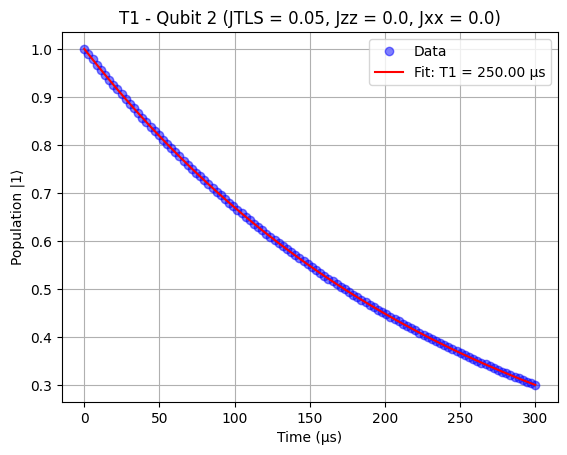

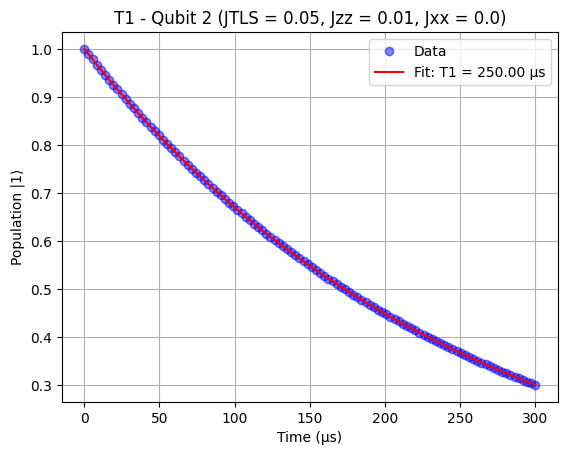

In [6]:
# T1 measurement for Qubit 2 
SYSTEM_PARAMS["Jzz"] = 0.00
H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=SYSTEM_PARAMS)

psi0 = tensor(basis(2,1), basis(2,0), basis(2,1))  # |1⟩|0⟩|1⟩

solve_t1(H, psi0, tlist, c_ops, [sz_q2], ret_pop=False)
plot_t1(H, psi0, tlist, c_ops, [sz_q2], "Qubit 2", SYSTEM_PARAMS)

SYSTEM_PARAMS["Jzz"] = 0.01
H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=SYSTEM_PARAMS)
psi0 = tensor(basis(2,1), basis(2,0), basis(2,1))  # |1⟩|0⟩|1⟩

solve_t1(H, psi0, tlist, c_ops, [sz_q2], ret_pop=False)
plot_t1(H, psi0, tlist, c_ops, [sz_q2], "Qubit 2", SYSTEM_PARAMS)

plt.show()

# T2 measurement for Qubit 1 

[5.00014726e-01 6.26549642e+01 3.20000629e+00 1.74235535e-05
 5.00000011e-01]
[5.00015814e-01 6.26482360e+01 3.24000638e+00 1.82727112e-05
 5.00000023e-01]


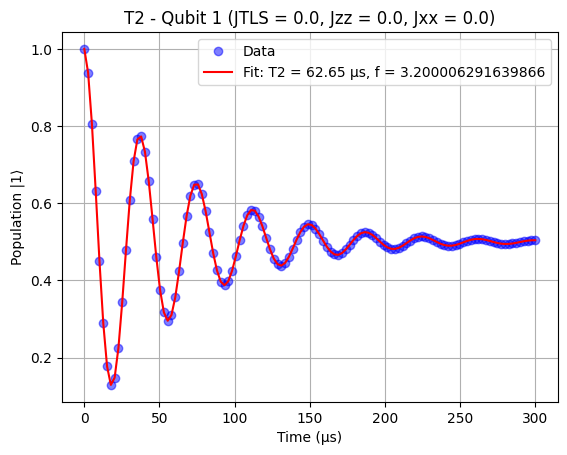

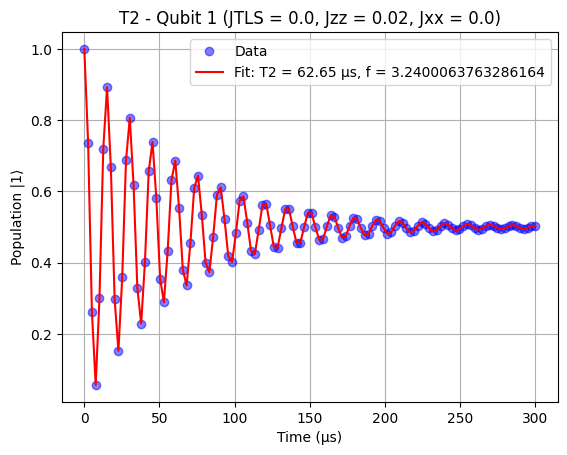

In [63]:
n = tensor(sigmam().dag()*sigmam(), identity(2), identity(2))

# T2 measurement for Qubit 1 
SYSTEM_PARAMS["Jzz"] = 0.0  #0.0
SYSTEM_PARAMS["JTLS"] = 0.0 #0.05
H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=SYSTEM_PARAMS)

psi0 = tensor((basis(2,1) + basis(2,0)).unit(), basis(2,1), basis(2,1))  # |+⟩|1⟩|1⟩


first_guess = [0.5, 1.0 / SYSTEM_PARAMS["dephasing"]["q1"], SYSTEM_PARAMS["fq1"], 0.0, 0.5]
#first_guess = [0.5, 1.0 / SYSTEM_PARAMS["dephasing"]["q1"], 3.1, 0.0, 0.5]

solve_t2(H, psi0, tlist, c_ops, [sx_q1], first_guess, ret_pop=False, use_fit_gauss=False)
plot_t2(H, psi0, tlist, c_ops, [sx_q1], first_guess, "Qubit 1", SYSTEM_PARAMS,  use_fit_gauss=False)
#plt.plot(tlist, make_population(sz_analytic(tlist, 1.0/180)), label="Analytic")

# with coupling
SYSTEM_PARAMS["Jzz"] = 0.02
H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=SYSTEM_PARAMS)
psi0 = tensor((basis(2,1) + basis(2,0)).unit(), basis(2,1), basis(2,1))  # |+⟩|1⟩|1⟩

first_guess = [0.5, 1.0 / SYSTEM_PARAMS["dephasing"]["q1"], SYSTEM_PARAMS["fq1"], 0.0, 0.5]

solve_t2(H, psi0, tlist, c_ops, [sx_q1], first_guess, ret_pop=False)
plot_t2(H, psi0, tlist, c_ops, [sx_q1], first_guess, "Qubit 1", SYSTEM_PARAMS)
#plt.plot(tlist, make_population(sz_analytic(tlist, 1.0/180)), label="Analytic")

plt.show()

# T2 measurement for Qubit 2 

[4.99259732e-01 7.61728474e+01 3.35041775e+00 2.65457843e-04
 5.00004230e-01]
[5.00017333e-01 7.54948562e+01 3.37000667e+00 2.43211699e-05
 4.99999927e-01]


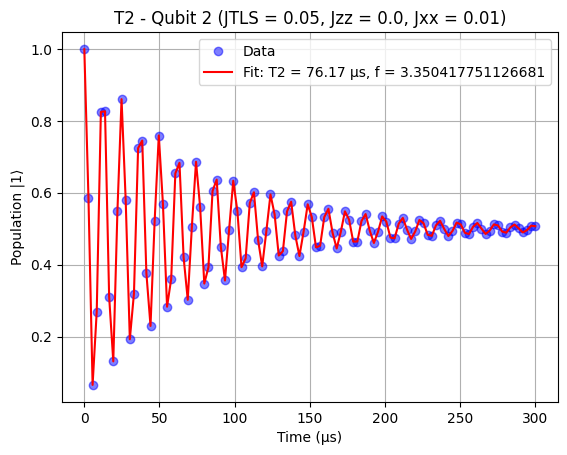

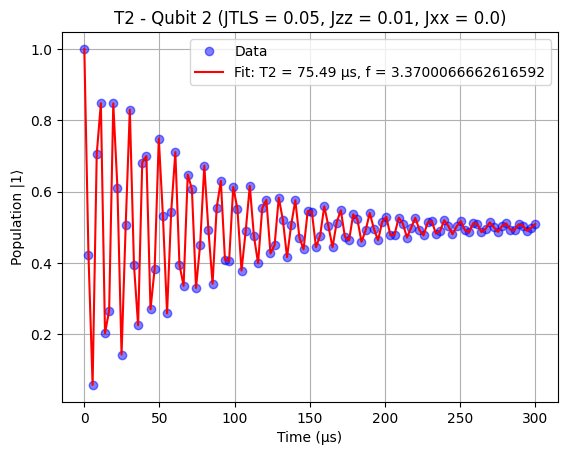

In [8]:
# T2 measurement for Qubit 2 
SYSTEM_PARAMS["Jzz"] = 0.00
SYSTEM_PARAMS["Jxx"] = 0.01
H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=SYSTEM_PARAMS)

psi0 = tensor(basis(2,1), (basis(2,1) + basis(2,0)).unit(), basis(2,1))  # |+⟩|1⟩|1⟩

first_guess = [0.5, 1.0 / SYSTEM_PARAMS["dephasing"]["q2"], SYSTEM_PARAMS["fq2"], 0.0, 0.5]

solve_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, ret_pop=False)
plot_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, "Qubit 2", SYSTEM_PARAMS)

# with coupling
SYSTEM_PARAMS["Jzz"] = 0.01
SYSTEM_PARAMS["Jxx"] = 0.00
H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=SYSTEM_PARAMS)

psi0 = tensor(basis(2,1), (basis(2,1) + basis(2,0)).unit(), basis(2,1))  # |+⟩|1⟩|1⟩

first_guess = [0.5, 1.0 / SYSTEM_PARAMS["dephasing"]["q2"], SYSTEM_PARAMS["fq2"], 0.0, 0.5]

solve_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, ret_pop=False)
plot_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, "Qubit 2", SYSTEM_PARAMS)
plt.show()

In [9]:
# 

[4.99259732e-01 7.61728474e+01 3.35041775e+00 2.65457843e-04
 5.00004230e-01]
[5.00017333e-01 7.54948562e+01 3.37000667e+00 2.43211699e-05
 4.99999927e-01]


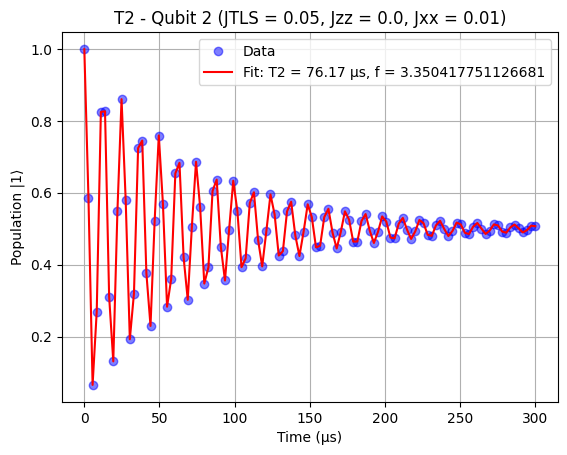

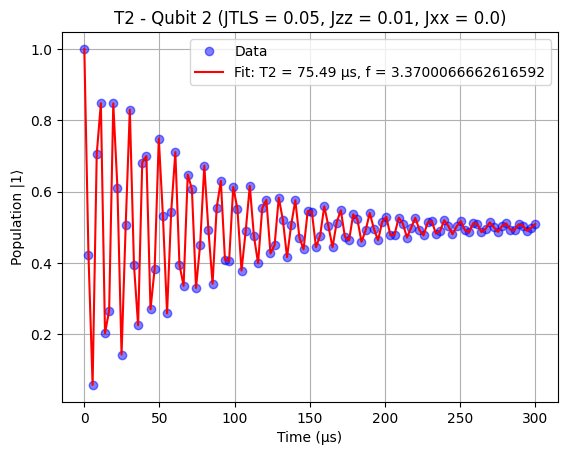

In [10]:
# T2 measurement for Qubit 2 
SYSTEM_PARAMS["Jzz"] = 0.00
SYSTEM_PARAMS["Jxx"] = 0.01
H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=SYSTEM_PARAMS)

psi0 = tensor(basis(2,1), (basis(2,1) + basis(2,0)).unit(), basis(2,1))  # |+⟩|1⟩|1⟩

first_guess = [0.5, 1.0 / SYSTEM_PARAMS["dephasing"]["q2"], SYSTEM_PARAMS["fq2"], 0.0, 0.5]

solve_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, ret_pop=False)
plot_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, "Qubit 2", SYSTEM_PARAMS)

# with coupling
SYSTEM_PARAMS["Jzz"] = 0.01
SYSTEM_PARAMS["Jxx"] = 0.00
H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=SYSTEM_PARAMS)

psi0 = tensor(basis(2,1), (basis(2,1) + basis(2,0)).unit(), basis(2,1))  # |+⟩|1⟩|1⟩

first_guess = [0.5, 1.0 / SYSTEM_PARAMS["dephasing"]["q2"], SYSTEM_PARAMS["fq2"], 0.0, 0.5]

solve_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, ret_pop=False)
plot_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, "Qubit 2", SYSTEM_PARAMS)
plt.show()

# Scanning Jzz

# Scan Q1

  0%|          | 0/10 [00:00<?, ?it/s]

[ 5.00014693e-01  6.26549522e+01  6.99937175e-02 -2.09583457e-05
  4.99999781e-01]


100%|██████████| 10/10 [00:48<00:00,  4.86s/it]


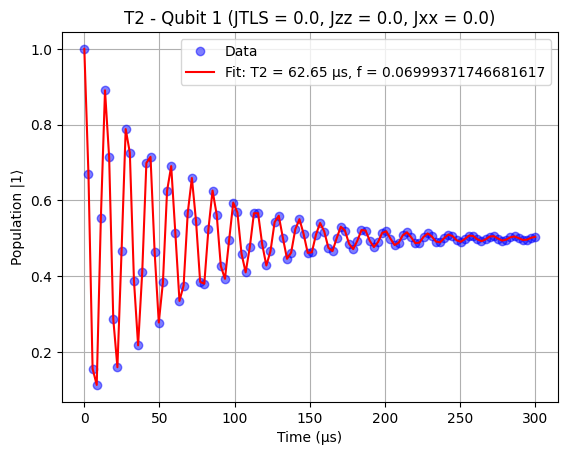

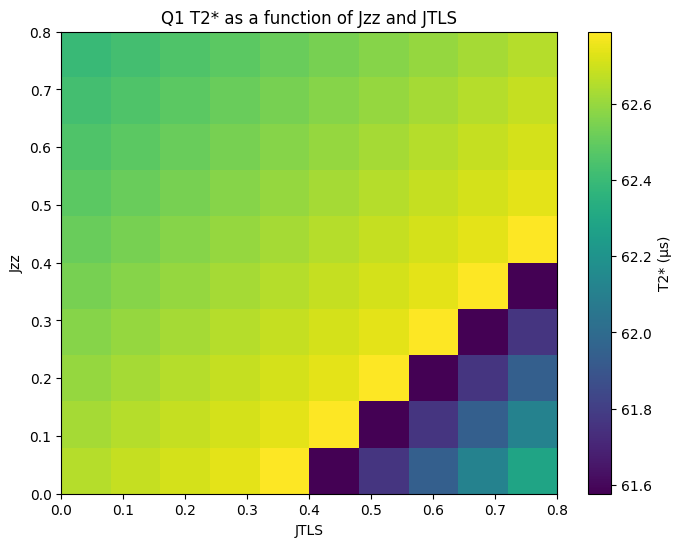

In [11]:

# Define parameter ranges
Jzz_vals = np.linspace(0.00, 0.80, 10)
JTLS_vals = np.linspace(0.00, 0.80, 10)
T2_matrix = np.zeros((len(Jzz_vals), len(JTLS_vals)))

# Base system parameters (without Jzz and JTLS)
base_params = SYSTEM_PARAMS.copy()

tlist = base_params["time_points"]
do_print = True
for i, Jzz in enumerate(tqdm(Jzz_vals)):
    for j, JTLS in enumerate(JTLS_vals):

        # Update parameters for this scan
        params = base_params.copy()
        params["Jzz"] = Jzz
        params["JTLS"] = JTLS

        # Setup system
        H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=params)
        psi0 = tensor( (basis(2, 0) + basis(2, 1)).unit(), basis(2, 1),  basis(2, 1))  # |+⟩|1⟩|1⟩
        first_guess = [0.5, 1.0 / params["dephasing"]["q1"], params["fq1"], 0.0, 0.5]

        # Solve T2 and store the fitted T2 value
        try:
            fit_par = solve_t2(H, psi0, tlist, c_ops, [sx_q1], first_guess, ret_pop=False, use_fit_gauss=True)
        except:
            print(f"Error solving T2 for Jzz={Jzz}, JTLS={JTLS}")
            continue 
  
        if fit_par[1] > 85:
            plot_t2(H, psi0, tlist, c_ops, [sx_q1], fit_par, "Qubit 1", params)
            fit_par[1] = 60

        if do_print:
            plot_t2(H, psi0, tlist, c_ops, [sx_q1], fit_par, "Qubit 1", params)
            do_print = False

        T2_matrix[i, j] = fit_par[1]  # T2* is the second parameter
            

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(T2_matrix, origin='lower', aspect='auto',
           extent=[JTLS_vals[0], JTLS_vals[-1], Jzz_vals[0], Jzz_vals[-1]],
           cmap='viridis')
plt.colorbar(label='T2* (μs)')
plt.xlabel('JTLS')
plt.ylabel('Jzz')
plt.title('Q1 T2* as a function of Jzz and JTLS')
plt.show()

#print(T2_matrix)

# Scan Q2

  0%|          | 0/10 [00:00<?, ?it/s]

[5.00017303e-01 7.54995225e+01 8.00066268e-02 2.37987500e-05
 4.99999929e-01]


100%|██████████| 10/10 [01:08<00:00,  6.84s/it]


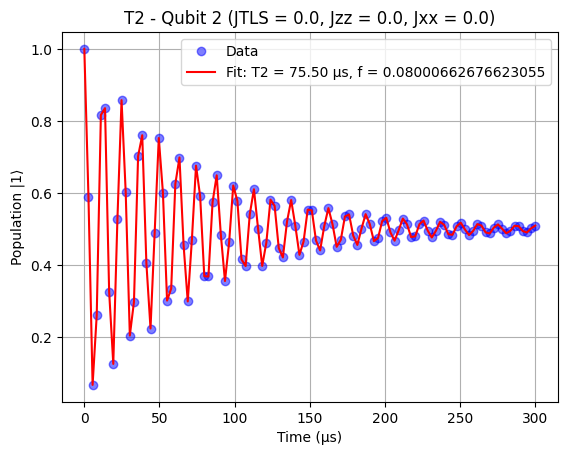

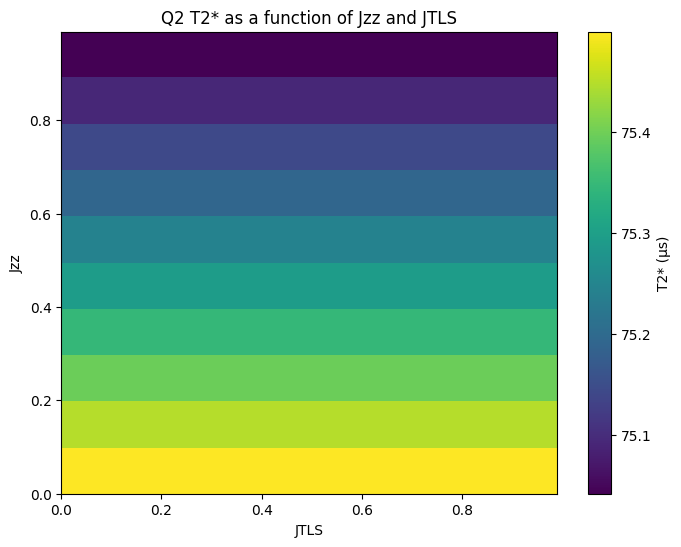

In [12]:

# Define parameter ranges
Jzz_vals = np.linspace(0.00, 0.99, 10)
JTLS_vals = np.linspace(0.00, 0.99, 10)
T2_matrix = np.zeros((len(Jzz_vals), len(JTLS_vals)))

# Base system parameters (without Jzz and JTLS)
base_params = SYSTEM_PARAMS.copy()

tlist = base_params["time_points"]
do_print = True
for i, Jzz in enumerate(tqdm(Jzz_vals)):
    for j, JTLS in enumerate(JTLS_vals):

        # Update parameters for this scan
        params = base_params.copy()
        params["Jzz"] = Jzz
        params["JTLS"] = JTLS

        # Setup system
        H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=params)
        psi0 = tensor(  basis(2, 1), (basis(2, 0) + basis(2, 1)).unit(), basis(2, 1))  # |1⟩|+⟩|1⟩
        first_guess = [0.5, 1.0 / params["dephasing"]["q2"], params["fq2"], 0.0, 0.5]

        # Solve T2 and store the fitted T2 value
        try:
            fit_par = solve_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, ret_pop=False, use_fit_gauss=True)
        except:
            print(f"Error solving T2 for Jzz={Jzz}, JTLS={JTLS}")
            continue 
  
        if fit_par[1] < 20:
            plot_t2(H, psi0, tlist, c_ops, [sx_q2], fit_par, "Qubit 2", params)
            fit_par[1] = 75

        if do_print:
            plot_t2(H, psi0, tlist, c_ops, [sx_q2], fit_par, "Qubit 2", params)
            do_print = False

        T2_matrix[i, j] = fit_par[1]  # T2* is the second parameter
            

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(T2_matrix, origin='lower', aspect='auto',
           extent=[JTLS_vals[0], JTLS_vals[-1], Jzz_vals[0], Jzz_vals[-1]],
           cmap='viridis')
plt.colorbar(label='T2* (μs)')
plt.xlabel('JTLS')
plt.ylabel('Jzz')
plt.title('Q2 T2* as a function of Jzz and JTLS')
plt.show()

#print(T2_matrix)

# Scan Jzz and JTLS for Qubit 1

  0%|          | 0/10 [00:00<?, ?it/s]

[5.00017303e-01 7.54995225e+01 8.00066268e-02 2.37987500e-05
 4.99999929e-01]


100%|██████████| 10/10 [01:07<00:00,  6.73s/it]


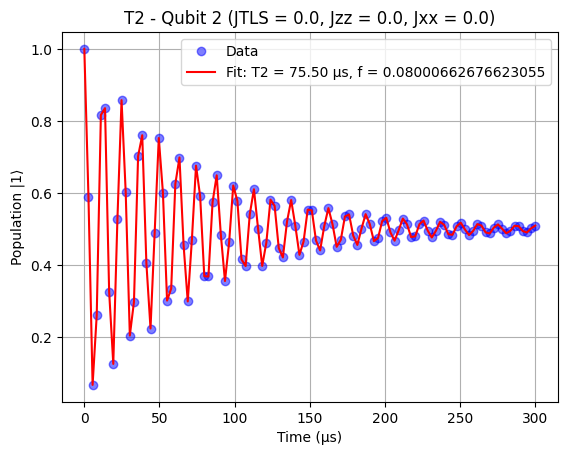

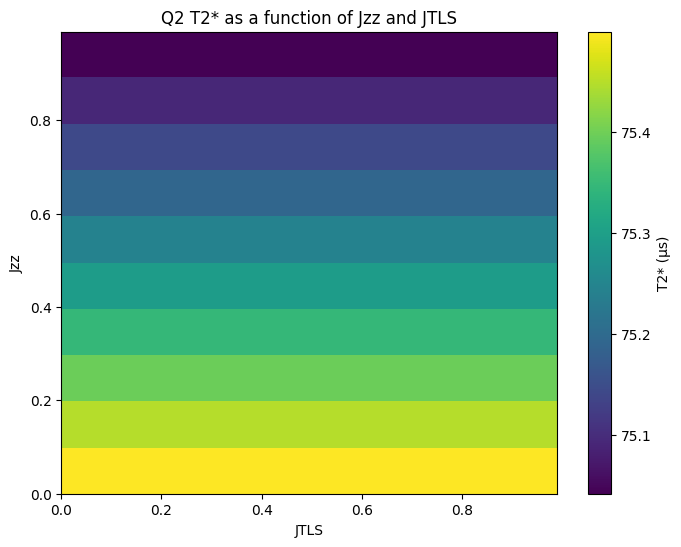

In [13]:

# Define parameter ranges
Jzz_vals = np.linspace(0.00, 0.99, 10)
JTLS_vals = np.linspace(0.00, 0.99, 10)
fTLS_vals = np.linspace(0.00, 0.99, 10)
T2_matrix = np.zeros((len(Jzz_vals), len(JTLS_vals)))

# Base system parameters (without Jzz and JTLS)
base_params = SYSTEM_PARAMS.copy()

tlist = base_params["time_points"]
do_print = True
for i, Jzz in enumerate(tqdm(Jzz_vals)):
    for j, JTLS in enumerate(JTLS_vals):

        # Update parameters for this scan
        params = base_params.copy()
        params["Jzz"] = Jzz
        params["JTLS"] = JTLS

        # Setup system
        H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=params)
        psi0 = tensor(  basis(2, 1), (basis(2, 0) + basis(2, 1)).unit(), basis(2, 1))  # |1⟩|+⟩|1⟩
        first_guess = [0.5, 1.0 / params["dephasing"]["q2"], params["fq2"], 0.0, 0.5]

        # Solve T2 and store the fitted T2 value
        try:
            fit_par = solve_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, ret_pop=False, use_fit_gauss=True)
        except:
            print(f"Error solving T2 for Jzz={Jzz}, JTLS={JTLS}")
            continue 
  
        if fit_par[1] < 20:
            plot_t2(H, psi0, tlist, c_ops, [sx_q2], fit_par, "Qubit 2", params)
            fit_par[1] = 75

        if do_print:
            plot_t2(H, psi0, tlist, c_ops, [sx_q2], fit_par, "Qubit 2", params)
            do_print = False

        T2_matrix[i, j] = fit_par[1]  # T2* is the second parameter
            

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(T2_matrix, origin='lower', aspect='auto',
           extent=[JTLS_vals[0], JTLS_vals[-1], Jzz_vals[0], Jzz_vals[-1]],
           cmap='viridis')
plt.colorbar(label='T2* (μs)')
plt.xlabel('JTLS')
plt.ylabel('Jzz')
plt.title('Q2 T2* as a function of Jzz and JTLS')
plt.show()

#print(T2_matrix)

# Q1 (Q5)  T2 Freq scan

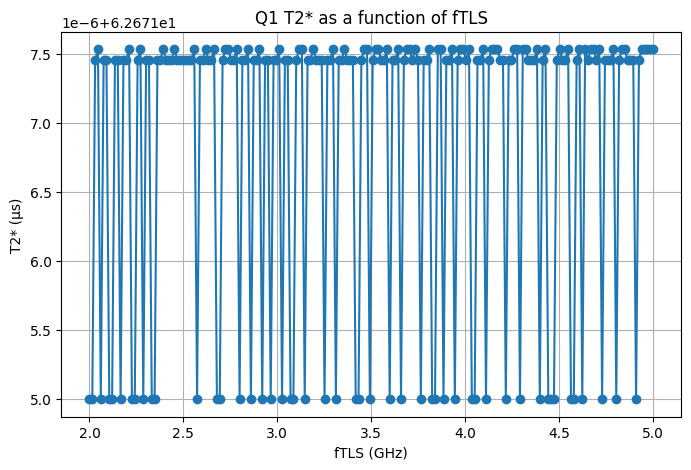

In [58]:
# Define parameter ranges
SYSTEM_PARAMS["Jzz"] = 0.00
SYSTEM_PARAMS["Jxx"] = 0.00
SYSTEM_PARAMS["JTLS"] = 0.05

shift = 1.5 # in Ghz
fTLS_vals = np.linspace(3.5-shift, 3.5+shift, 200)  # Example: scan fTLS from 3.0 to 3.5 GHz
T2_vec = np.zeros(len(fTLS_vals))

# Base system parameters (without fTLS)
base_params = SYSTEM_PARAMS.copy()
tlist = base_params["time_points"]

for k, fTLS in enumerate(fTLS_vals):
    # Update parameters for this scan
    params = base_params.copy()
    params["fTLS"] = fTLS

    # Setup system
    H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=params)
    psi0 = tensor((basis(2, 0) + basis(2, 1)).unit(), basis(2,1), basis(2, 1))  # |+⟩|1⟩|1⟩
    first_guess = [0.5, 1.0 / params["dephasing"]["q1"], params["fq1"], 0.0, 0.5]

    # Solve T2 and store the fitted T2 value
    try:
        fit_par = solve_t2(H, psi0, tlist, c_ops, [sx_q1], first_guess, ret_pop=False, use_fit_gauss=True)
        T2_vec[k] = fit_par[1]  # T2* is the second parameter
    except Exception as e:
        print(f"Error solving T2 for fTLS={fTLS}: {e}")
        T2_vec[k] = np.nan

# Plot T2* vs fTLS
plt.figure(figsize=(8, 5))
plt.plot(fTLS_vals, T2_vec, marker='o')
plt.xlabel('fTLS (GHz)')
plt.ylabel('T2* (μs)')
plt.title('Q1 T2* as a function of fTLS')
plt.grid(True)
plt.show()

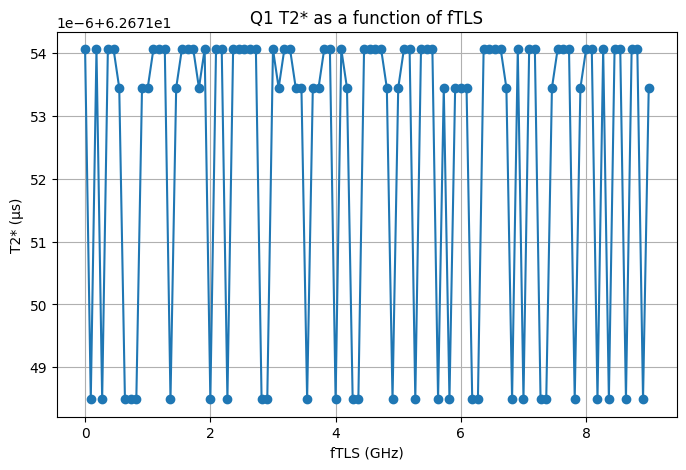

In [38]:
# Define parameter ranges
SYSTEM_PARAMS["Jzz"] = 0.00
SYSTEM_PARAMS["Jxx"] = 0.00
SYSTEM_PARAMS["JTLS"] = 0.05

shift = 0.06 # in Ghz

x = np.linspace(0, 9, 100)  # 0 to X
y = tls_f_shift(x, 3.0, 0.6, 2.5, np.pi)

fTLS_vals = y
T2_vec = np.zeros(len(fTLS_vals))

# Base system parameters (without fTLS)
base_params = SYSTEM_PARAMS.copy()
tlist = base_params["time_points"]

for k, fTLS in enumerate(fTLS_vals):
    # Update parameters for this scan
    params = base_params.copy()
    params["fTLS"] = fTLS

    # Setup system
    H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=params)
    psi0 = tensor((basis(2, 0) + basis(2, 1)).unit(), basis(2,1), basis(2, 1))  # |+⟩|1⟩|1⟩
    first_guess = [0.5, 1.0 / params["dephasing"]["q1"], params["fq1"], 0.0, 0.5]

    # Solve T2 and store the fitted T2 value
    try:
        fit_par = solve_t2(H, psi0, tlist, c_ops, [sx_q1], first_guess, ret_pop=False, use_fit_gauss=True)
        T2_vec[k] = fit_par[1]  # T2* is the second parameter
    except Exception as e:
        print(f"Error solving T2 for fTLS={fTLS}: {e}")
        T2_vec[k] = np.nan

# Plot T2* vs fTLS
plt.figure(figsize=(8, 5))
plt.plot(x, T2_vec, marker='o')
plt.xlabel('fTLS (GHz)')
plt.ylabel('T2* (μs)')
plt.title('Q1 T2* as a function of fTLS')
plt.grid(True)
plt.show()

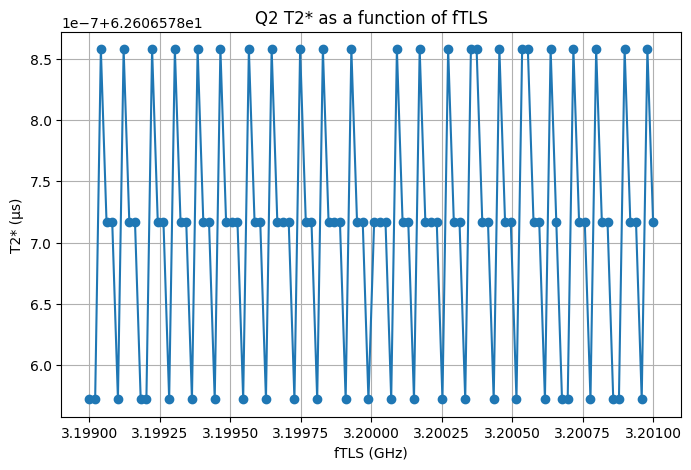

In [17]:
# Define parameter ranges
SYSTEM_PARAMS["JTLS"] = 0.05 #0.05

fTLS_vals = np.linspace(3.2-0.001, 3.2+0.001, 100)  # Example: scan fTLS from 3.0 to 3.5 GHz
T2_vec = np.zeros(len(fTLS_vals))

# Base system parameters (without fTLS)
base_params = SYSTEM_PARAMS.copy()
tlist = base_params["time_points"]

for k, fTLS in enumerate(fTLS_vals):
    # Update parameters for this scan
    params = base_params.copy()
    params["fTLS"] = fTLS

    # Setup system
    H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=params)
    psi0 = tensor( (basis(2, 0) + basis(2, 1)).unit(), basis(2, 1), basis(2, 1))  # |1⟩|+⟩|1⟩
    first_guess = [0.5, 1.0 / params["dephasing"]["q2"], params["fq2"], 0.0, 0.5]

    # Solve T2 and store the fitted T2 value
    try:
        fit_par = solve_t2(H, psi0, tlist, c_ops, [sx_q1], first_guess, ret_pop=False, use_fit_gauss=True)
        T2_vec[k] = fit_par[1]  # T2* is the second parameter
    except Exception as e:
        print(f"Error solving T2 for fTLS={fTLS}: {e}")
        T2_vec[k] = np.nan

# Plot T2* vs fTLS
plt.figure(figsize=(8, 5))
plt.plot(fTLS_vals, T2_vec, marker='o')
plt.xlabel('fTLS (GHz)')
plt.ylabel('T2* (μs)')
plt.title('Q2 T2* as a function of fTLS')
plt.grid(True)
plt.show()

c:\Users\jayamao\.conda\envs\qiskit\lib\site-packages\qubit_zz_coupling\utils.py:28: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-t / T1) + c
c:\Users\jayamao\.conda\envs\qiskit\lib\site-packages\qubit_zz_coupling\core.py:96: OptimizeWarning: Covariance of the parameters could not be estimated
  fit_par, _ = curve_fit(exp_decay, tlist, pop, p0=[1.0, 20, 0])


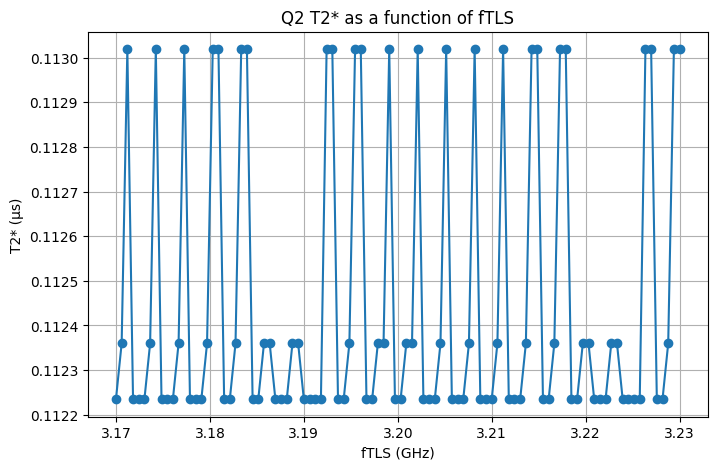

In [16]:
# Define parameter ranges
SYSTEM_PARAMS["JTLS"] = 0.05 #0.05
SYSTEM_PARAMS["Jzz"] = 0.2 #0.05

fTLS_vals = np.linspace(3.2-0.03, 3.2+0.03, 100)  # Example: scan fTLS from 3.0 to 3.5 GHz
T2_vec = np.zeros(len(fTLS_vals))

# Base system parameters (without fTLS)
base_params = SYSTEM_PARAMS.copy()
tlist = base_params["time_points"]

for k, fTLS in enumerate(fTLS_vals):
    # Update parameters for this scan
    params = base_params.copy()
    params["fTLS"] = fTLS

    # Setup system
    H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=params)
    psi0 = tensor( (basis(2, 0) + basis(2, 1)).unit(), basis(2, 1), basis(2, 1))  # |1⟩|+⟩|1⟩
    first_guess = [0.5, 1.0 / params["dephasing"]["q2"], params["fq2"], 0.0, 0.5]

    # Solve T2 and store the fitted T2 value
    try:
        fit_par = solve_t1(H, psi0, tlist, c_ops, [sx_q1], ret_pop=False)
        T2_vec[k] = fit_par[1]  # T2* is the second parameter
    except Exception as e:
        print(f"Error solving T2 for fTLS={fTLS}: {e}")
        T2_vec[k] = np.nan

# Plot T2* vs fTLS
plt.figure(figsize=(8, 5))
plt.plot(fTLS_vals, T2_vec, marker='o')
plt.xlabel('fTLS (GHz)')
plt.ylabel('T2* (μs)')
plt.title('Q2 T2* as a function of fTLS')
plt.grid(True)
plt.show()

In [ ]:

# Define parameter ranges
Jzz_vals = np.linspace(0.01, 0.02, 21)
JTLS_vals = np.linspace(0.01, 0.10, 21)
T2_matrix = np.zeros((len(Jzz_vals), len(JTLS_vals)))

# Base system parameters (without Jzz and JTLS)
base_params = SYSTEM_PARAMS.copy()

tlist = base_params["time_points"]

counter = 0
tot =  len(Jzz_vals) * len(JTLS_vals)

for i, Jzz in enumerate(Jzz_vals):
    for j, JTLS in enumerate(JTLS_vals):
        if counter % 10 == 0 :
            print(f'loop: {counter}/{tot}')
        counter+=1

        # Update parameters for this scan
        params = base_params.copy()
        params["Jzz"] = Jzz
        params["JTLS"] = JTLS

        # Setup system
        H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=params)
        psi0 = tensor(  basis(2, 1), (basis(2, 0) + basis(2, 1)).unit(),  basis(2, 1))  # |1⟩|+⟩|1⟩
        first_guess = [0.5, 1.0 / params["dephasing"]["q2"], params["fq2"], 0.0, 0.5]

        # Solve T2 and store the fitted T2 value
        try:
            fit_par = solve_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, ret_pop=False, use_fit_gauss=True)
        except:
            print(f"Error solving T2 for Jzz={Jzz}, JTLS={JTLS}")
            continue 
        T2_matrix[i, j] = fit_par[1]  # T2* is the second parameter

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(T2_matrix, origin='lower', aspect='auto',
           extent=[JTLS_vals[0], JTLS_vals[-1], Jzz_vals[0], Jzz_vals[-1]],
           cmap='viridis')
plt.colorbar(label='T2* (μs)')
plt.xlabel('JTLS')
plt.ylabel('Jzz')
plt.title('Q1 T2* as a function of Jzz and JTLS')
plt.show()

#print(T2_matrix)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qubit_zz_coupling.core import setup_operators, solve_t2
from qutip import basis, tensor

# Define parameter ranges
Jzz_vals = np.linspace(0.01, 0.05, 21)
Jxx_vals = np.linspace(0.01, 0.15, 21)
T2_matrix = np.zeros((len(Jzz_vals), len(Jxx_vals)))

# Base system parameters (without Jzz and Jxx)
base_params = {
    "fq1": 3.2,
    "fq2": 3.35,
    "fTLS": 3.2,
    "relaxation": {"q1": 1/20, "q2": 1/25, "TLS": 1/5},
    "dephasing": {"q1": 1/15, "q2": 1/18, "TLS": 1/3},
    "JTLS": 0.05,
    "time_points": np.linspace(0, 100, 200)
}

tlist = base_params["time_points"]

for i, Jzz in enumerate(Jzz_vals):
    for j, Jxx in enumerate(Jxx_vals):
        # Update parameters for this scan
        params = base_params.copy()
        params["Jzz"] = Jzz
        params["Jxx"] = Jxx

        # Setup system
        H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=params)
        psi0 = tensor(basis(2, 1), (basis(2, 0) + basis(2, 1)).unit(), basis(2, 1))  # |+⟩|1⟩|1⟩
        first_guess = [0.5, 1.0 / params["dephasing"]["q2"], params["fq2"], 0.0, 0.5]

        # Solve T2 and store the fitted T2 value
        try:
            fit_par = solve_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, ret_pop=False)
        except Exception as e:
            print(f"Error solving T2 for Jzz={Jzz}, Jxx={Jxx}: {e}")
            continue
        T2_matrix[i, j] = fit_par[1]  # T2* is the second parameter

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(T2_matrix, origin='lower', aspect='auto',
           extent=[Jxx_vals[0], Jxx_vals[-1], Jzz_vals[0], Jzz_vals[-1]],
           cmap='viridis')
plt.colorbar(label='T2* (μs)')
plt.xlabel('Jxx')
plt.ylabel('Jzz')
plt.title('T2* as a function of Jzz and Jxx')
plt.show()

In [ ]:
# single qbit
sz_q1 = sigmaz()

H = 2 * np.pi * 3.2 / 2 * sz_q1

c_ops = [
    np.sqrt(1/20) * sigmam(),
    np.sqrt((1/18)) * sigmaz(),
]

tlist = np.linspace(0, 300, 100)

# T2 measurement for Qubit 1 
psi0 = (basis(2, 0) + basis(2, 1)).unit()  # |+⟩|1⟩|1⟩


first_guess = [0.5, 1.0 / (1/18), # best guess
                  3.2, 0.0, 0.5]

solve_t2(H, psi0, tlist, c_ops, [sigmax()], first_guess, ret_pop=False)
plot_t2(H, psi0, tlist, c_ops, [sigmax()], first_guess, "Qubit 2", SYSTEM_PARAMS)
plt.show()

